# Homework #1

## Preparations

Import libraries needed:

In [4]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# DecisionTree
from sklearn.tree import DecisionTreeClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# DummyClassifier
from sklearn.dummy import DummyClassifier

# LogisticRegression
from sklearn.linear_model import LogisticRegression

# Pipeline
from sklearn.pipeline import Pipeline

# HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

Download pre-trained LM:

In [ ]:
!python3 -m spacy download en_core_web_sm

Set a display option in Pandas:

In [6]:
pd.set_option('max_colwidth', 400)

## Data manipulation

Load SMS Spam Collection Dataset in csv

In [13]:
!wget -q https://raw.githubusercontent.com/whatever125/nlp_itmo/hw1/homework_1/spam.csv
data = pd.read_csv('spam.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [14]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [15]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

## Text preprocessing

Load spacy english stopwords:

In [16]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"well almost wherein on we no top whose n’t each the i or therefore might within former empty show only below none many yourselves whenever anyhow she amount yours unless around somehow off twelve two ‘ll never already over while through noone whole about everything beside is an more everywhere than rather upon full toward being ours yourself others made all thereby name may be give ’ve throughout still although whence further his their whereby twenty along for nine though even herein by that first sometimes these otherwise also whoever without other namely three very ‘d beyond where forty latter must regarding him into of whom something because but every if six both alone latterly will perhaps eleven how front hereby much either ’d it indeed now nothing next a at during wherever one thru any make several seems say used enough ‘s go n‘t among whereupon ‘re neither ever 've ‘m serious too meanwhile nor until again does sixty just who ’m from nowhere therein was and had else doing across

Clean data['text'], add 'cleaned_text':

In [17]:
%%time

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)

CPU times: user 30.9 s, sys: 98 ms, total: 31 s
Wall time: 32.3 s


In [18]:
data[:5]

,label,text,cleaned_text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",jurong point crazy available bugis n great world la e buffet cine get amore wat
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry wkly comp win fa cup final tkts text fa receive entry question(std txt rate)t&c apply 08452810075over18
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives around here though",nah think go usf live


## Train/test split & fit

Split data into train and test sets:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

## Dummy prediction

In [20]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [21]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=2023).fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



## Custom GridSearch

In [22]:
def customGridSearch(pipeline, parameter_grid):
  grid_search = HalvingGridSearchCV(
      pipeline,
      param_grid=parameter_grid,
      n_jobs=-1,
      verbose=1,
      cv=3,
      scoring='f1',
      random_state=2023,
  )
  grid_search.fit(X_train, y_train)
  return grid_search

## Custom graph drawer

In [23]:
def show_results(grid_search):
  results = pd.DataFrame(grid_search.cv_results_)
  results["params_str"] = results.params.apply(str)
  results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
  mean_scores = results.pivot(
      index="iter",
      columns="params_str",
      values="mean_test_score",
  )
  ax = mean_scores.plot(legend=False, alpha=0.6)

  labels = [
      f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
      for i in range(grid_search.n_iterations_)
  ]

  ax.set_xticks(range(grid_search.n_iterations_))
  ax.set_xticklabels(labels, rotation=45, multialignment="left")
  ax.set_title("Scores of candidates over iterations")
  ax.set_ylabel("Mean test score", fontsize=15)
  ax.set_xlabel("Iterations", fontsize=15)
  plt.tight_layout()
  plt.grid()
  plt.show()

## CountVectorizer


### Logistic regression

In [24]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=2023))
    ]
)

In [25]:
parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [27]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1207
           1       0.97      0.63      0.76       186

    accuracy                           0.95      1393
   macro avg       0.96      0.81      0.87      1393
weighted avg       0.95      0.95      0.94      1393



In [28]:
grid_search.best_params_

{'clf__C': 0.5,
 'counter__max_df': 0.6,
 'counter__min_df': 0.01,
 'counter__ngram_range': (1, 2),
 'tfidf__norm': 'l2'}

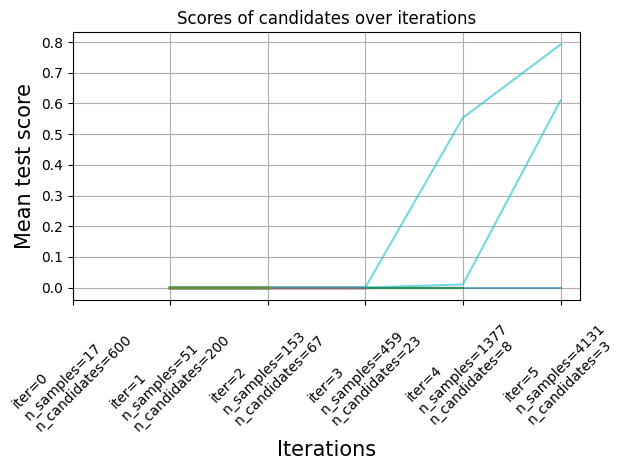

In [29]:
show_results(grid_search)

### Decision Tree

In [30]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(random_state=2023))
    ]
)

In [31]:
parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [33]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1207
           1       0.84      0.86      0.85       186

    accuracy                           0.96      1393
   macro avg       0.91      0.92      0.91      1393
weighted avg       0.96      0.96      0.96      1393



In [34]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'counter__max_df': 0.6,
 'counter__min_df': 0.001,
 'counter__ngram_range': (1, 1),
 'tfidf__norm': 'l1'}

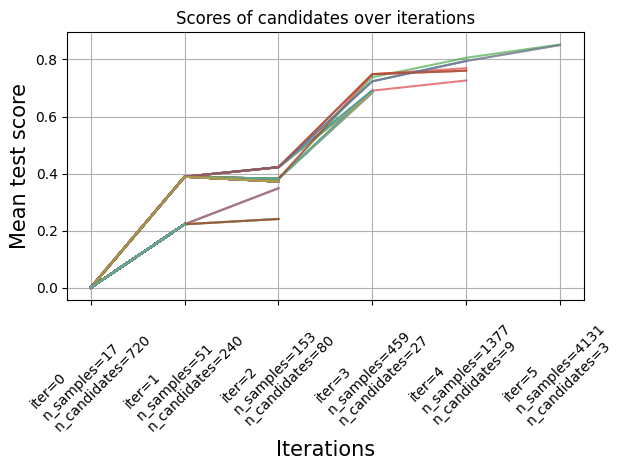

In [35]:
show_results(grid_search)

### Naive Bayes

In [36]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

In [37]:
parameter_grid = {
    "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    "counter__min_df": [0.001, 0.01, 0.1],
    "counter__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False]
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [39]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.96      0.85      0.91       186

    accuracy                           0.98      1393
   macro avg       0.97      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



In [40]:
grid_search.best_params_

{'clf__alpha': 0.1,
 'clf__fit_prior': True,
 'counter__max_df': 0.6,
 'counter__min_df': 0.001,
 'counter__ngram_range': (1, 1),
 'tfidf__norm': 'l2'}

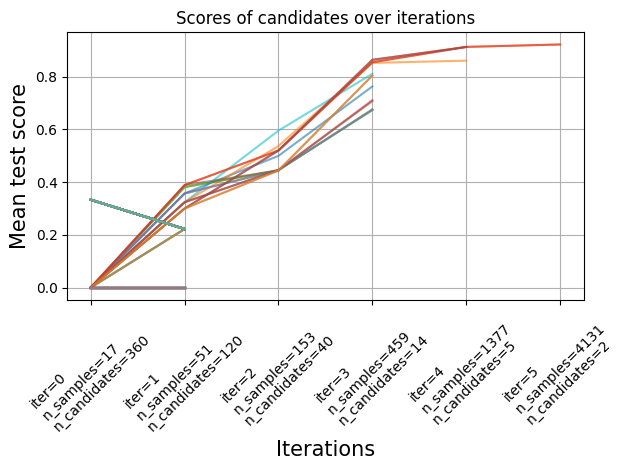

In [41]:
show_results(grid_search)

## TF-IDF

### Logistic regression

In [42]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=2023))
    ]
)

In [43]:
parameter_grid = {
    # "counter__max_df": [0.5, 0.6, 0.7, 0.8, 0.9],
    # "counter__min_df": [0.001, 0.01, 0.1],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [45]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1207
           1       0.99      0.69      0.81       186

    accuracy                           0.96      1393
   macro avg       0.97      0.84      0.89      1393
weighted avg       0.96      0.96      0.95      1393



In [46]:
grid_search.best_params_

{'clf__C': 1.0, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}

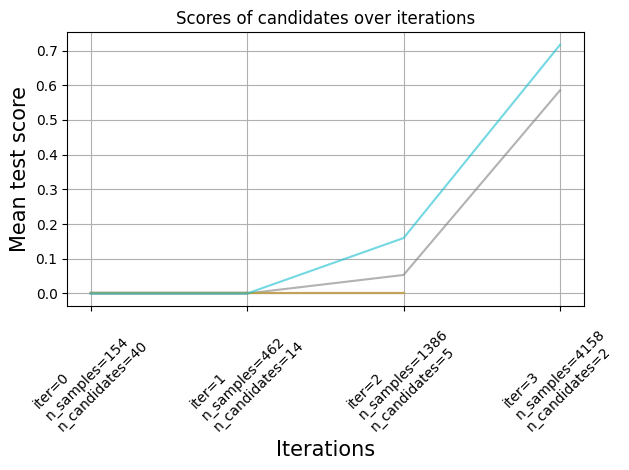

In [47]:
show_results(grid_search)

### Decision Tree

In [48]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier(random_state=2023))
    ]
)

In [49]:
parameter_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [51]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1207
           1       0.91      0.84      0.87       186

    accuracy                           0.97      1393
   macro avg       0.94      0.92      0.93      1393
weighted avg       0.97      0.97      0.97      1393



In [52]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 5,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l1'}

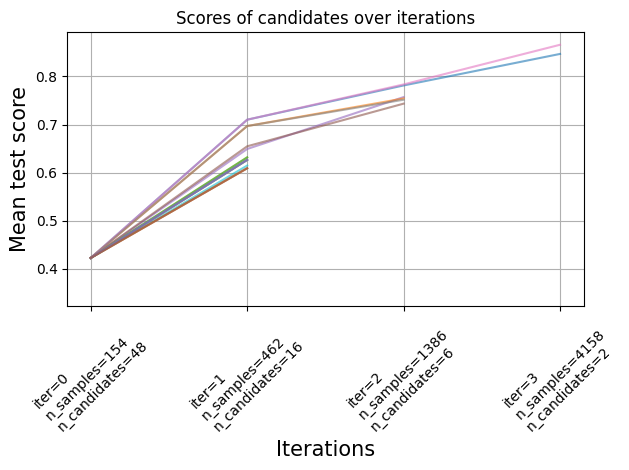

In [53]:
show_results(grid_search)

### Naive Bayes

In [54]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]
)

In [55]:
parameter_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "tfidf__norm": ("l1", "l2"),
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False]
}

In [ ]:
%%time

grid_search = customGridSearch(pipe, parameter_grid)
grid_search.fit(X_train, y_train)

In [57]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       0.97      0.90      0.93       186

    accuracy                           0.98      1393
   macro avg       0.98      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [58]:
grid_search.best_params_

{'clf__alpha': 0.1,
 'clf__fit_prior': True,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2'}

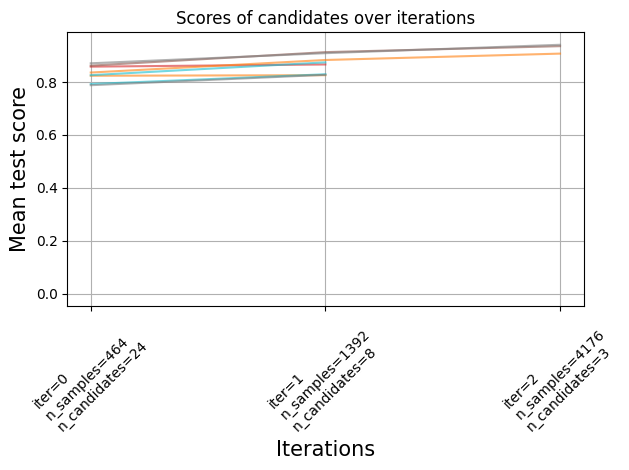

In [59]:
show_results(grid_search)

## Play with results

In [61]:
user_input = input("Enter a text message: \n")

user_input_processed = ' '.join(
        token.lemma_.lower() for token in nlp(user_input) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
)

print("User input processed:")
print(user_input_processed)

prediction = grid_search.best_estimator_.predict([user_input_processed])

print("Result:")
if prediction[0] == 1:
    print("The input is classified as SPAM")
else:
    print("The input is classified as NOT SPAM")

Enter a text message: 
Hello world! Get your prize at www.amazon.com/$$$$money
User input processed:
hello world prize www.amazon.com/$$$$money
Result:
The input is classified as SPAM


## Выводы

В результате работы с различными методами векторизациями текста и моделями классификации можно заметить:
- Использование TfidfVectorizer вместо CountVectorizer незначительно улучшает метрики
- Среди трех моделей классификации:
  - Logistic regression дает высокий precision, но низкий recall
  - Decision tree дает средний результат
  - Multinominal NB дает лучший результат с высоким precision и самым высоким recall

Таким образом, использование Multinominal NB в паре с TfidfVectorizer дает лучший результат